In [4]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import csv
import textwrap
from scipy.spatial.distance import cosine


In [5]:
import sys
sys.path.append('/Users/gabriellachronis/src/mprobert')

from helpers import bert_helper, datasets, grinders, helpers

import os, shutil
import numpy as np
import csv
import pickle

import pandas as pd

In [6]:
# initialize BERT model
(model, tokenizer) = bert_helper.initialize()

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmps2ou83qt
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

In [7]:
# get the sentences for the words

#words = ["madhouse", "asylum"]
#words = ["bishop", "rook"]
#words = ["hand", "thumb"]
#words = ["mouth", "lip"]
#words = ["goal", "quest"]
#words = ["bubble", "suds"]
#words = ["cuba", "jamaica"]
words = ["rabbit"]
word = ["rabbit"]
K = 8
layer = 7


In [8]:
"""
Construct a df with attributes 
    word: word in question
    sentence: sentence containing token of word
    tag: pos of word in sentence
    bnc_index: index of sentence in the BNC
"""
tokens = []


for word in words:
    with open('../data/word_data/'+word+'/BNC_tokens.csv', mode="r") as infile:
        fieldnames = ['word', 'sentence', 'tag', 'bnc_index']

        reader = csv.DictReader(infile, delimiter="\t", fieldnames=fieldnames)
        for row in reader:
            #print(row['vector'][2:-2])
            vectors = bert_helper.get_bert_vectors_for(row['word'], row['sentence'] , model, tokenizer)
            
            # looking at layer 8
            layer_vector = vectors[layer]
            row['vector'] =  layer_vector
            tokens.append(row)


            

In [9]:
"""
we want to look at how our stored clusterc compare to this example of metaphor
"""
sentence = "That man is like a %s." % word
man_is_a_word = {
    'word': word+'(_man_is_a)',
    'sentence': sentence,
    'vector': bert_helper.get_bert_vectors_for(word, sentence , model, tokenizer)[layer],
    #'cluster_id': 'special'
}
tokens.append(man_is_a_word)

df = pd.DataFrame.from_records(tokens)


In [10]:

"""
now we want to add a column to the dataframe with the cluster label for each sentence
"""
clusters = helpers.read_clusters(word)
clusters = clusters[clusters['k_clusters'] == K]
clusters = clusters[clusters['layer'] == layer]


uids = []
# iterate through each cluster
for cluster in clusters.itertuples():
    # iterate through the UIDS for this cluster
    for uid in cluster.sentence_uids:
        uids.append( (uid, str(cluster.cluster_id) ) )

# create new dataframe with UIDs mapped to cluster IDs
token_ids_with_cluster_ids = pd.DataFrame.from_records(uids, columns=['bnc_index', 'cluster_id'])

# join above array to main data array to add cluster_ids
data = df.merge(token_ids_with_cluster_ids, how='outer', on='bnc_index')
print(data)



                  word                                           sentence  \
0               rabbit    snags its circle through the eyes of a rabbit .   
1               rabbit                                       Peter Rabbit   
2               rabbit  And you said you 'd do rabbit today did n't you ?   
3               rabbit  And you said you 'd do rabbit today did n't you ?   
4               rabbit  He had never intended to turn the dog loose , ...   
..                 ...                                                ...   
198             rabbit  Kevin Irving 's ‘ father ’ writes to admit tha...   
199             rabbit  Chocolate run-outs are used , for example , fo...   
200             rabbit  Rumour has it they 've been perfecting the bel...   
201             rabbit                           Here is Rainbow Rabbit .   
202  rabbit(_man_is_a)                         That man is like a rabbit.   

       tag    bnc_index                                             vector 

In [11]:

small_dict = pd.DataFrame.from_records(man_is_a_word)
small_dict


,sentence,vector,word
0,That man is like a rabbit.,0.316280,rabbit(_man_is_a)
1,That man is like a rabbit.,0.007964,rabbit(_man_is_a)
2,That man is like a rabbit.,0.069396,rabbit(_man_is_a)
3,That man is like a rabbit.,0.123604,rabbit(_man_is_a)
4,That man is like a rabbit.,0.122948,rabbit(_man_is_a)
...,...,...,...
763,That man is like a rabbit.,-0.989847,rabbit(_man_is_a)
764,That man is like a rabbit.,0.213717,rabbit(_man_is_a)
765,That man is like a rabbit.,-0.006877,rabbit(_man_is_a)
766,That man is like a rabbit.,-0.325500,rabbit(_man_is_a)


In [12]:
"""
for each example we have containing word, what's the cosine between that and 'bob is a WORD?'
"""

pd.set_option('display.max_colwidth', None)


sims_to_target_word  = []
for row in data.itertuples():
    similarity = 1-cosine(row.vector, man_is_a_word['vector'])
    sims_to_target_word.append( (row.sentence, row.cluster_id, sentence, similarity ) )
pd.DataFrame.from_records(sims_to_target_word, columns = [ 'sentence_a', 'cluster_id', 'sentence_b', 'cosine'] ).sort_values(by=['cosine'], ascending=False)

,sentence_a,cluster_id,sentence_b,cosine
202,That man is like a rabbit.,NaN,That man is like a rabbit.,1.000000
61,I was just envisaging it being like a rabbit or something .,7,That man is like a rabbit.,0.942996
53,"Always at it , munch munch , nibble nibble , just like a rabbit .",7,That man is like a rabbit.,0.903852
167,I should hit him across the back of the neck like a rabbit .,NaN,That man is like a rabbit.,0.894541
113,A killed his baby thinking that it was a rabbit .,NaN,That man is like a rabbit.,0.890873
...,...,...,...,...
160,"In the S1 globular head region , rabbit smooth muscle MHC showed approximately 90% identity to the chicken gizzard ( 10 ) and chicken epithelial non-muscle MHC-A ( 11 ) genes .",NaN,That man is like a rabbit.,0.514332
133,"The first of these putative Na + /H + exchangers has 95% homology with the previously cloned human fibroblast Na + /H + exchanger , with which it also shares several functional characteristics , including extreme sensitivity to amiloride. furthermore , immunocytochemical studies showed that polyclonal antibodies to a fusion protein incorporating this sequence localise to basolateral but not apical membranes from rabbit ileum .",NaN,That man is like a rabbit.,0.506451
154,"For instance , constrictions in the rat aorta , dog coronary artery and saphenous vein , and the iliac artery and saphenous vein of the cyomologus monkey are mediated by receptors , where the type mediates constrictions of the rabbit pulmonary artery and saphenous vein , and the dog saphenous vein ( ) .",NaN,That man is like a rabbit.,0.497976
18,"Like other fellow scribblers whose squiggles seriously abuse the very title ‘ shorthand notebook ’ , I have nevertheless been generously given hours , sometimes even days , by sportsmen happy enough to rabbit on without so much as a penny piece being mentioned .",3,That man is like a rabbit.,0.490256


In [13]:
"""
Give a dummy cluster id to the target word
"""
data['cluster_id'][220] = 'Target'


In [14]:
# TSNE

print(data)

                  word  \
0               rabbit   
1               rabbit   
2               rabbit   
3               rabbit   
4               rabbit   
..                 ...   
198             rabbit   
199             rabbit   
200             rabbit   
201             rabbit   
202  rabbit(_man_is_a)   

                                                                                                                                                                                                                               sentence  \
0                                                                                                                                                                                       snags its circle through the eyes of a rabbit .   
1                                                                                                                                                                                                                        

In [15]:
X = data['vector']
X = X.to_list()
y = data['word']+data['cluster_id']
#print(y)
contexts = data['sentence']

feat_cols = [ 'dimension'+str(i) for i in range(len(X[0])) ]
df = pd.DataFrame(X,columns=feat_cols)

print(df)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
df['context'] = contexts

print(df)

X, y = None, None 

print('Size of the dataframe: {}'.format(df.shape))


     dimension0  dimension1  dimension2  dimension3  dimension4  dimension5  \
0      0.309081    0.252525   -0.059906    0.098673    0.089116    0.399476   
1     -0.523776   -0.511127    0.350216   -0.220446    0.328690    1.414236   
2      0.439747    0.037008   -0.321238   -0.018409    1.271600    0.514824   
3      0.439747    0.037008   -0.321238   -0.018409    1.271600    0.514824   
4      0.659870    0.111881    0.200573    0.572822   -0.029790   -0.298853   
..          ...         ...         ...         ...         ...         ...   
198    0.148363   -0.551094    0.386222   -0.406814    0.741462    0.664750   
199   -0.414592    0.380640    0.097387   -0.102787    0.232597    0.558989   
200    0.708642   -0.049910   -0.529751    0.225095    0.870864   -0.637777   
201    0.465877   -0.421158    0.127408    0.032568    0.489603    0.907021   
202    0.316280    0.007964    0.069396    0.123604    0.122948    0.673612   

     dimension6  dimension7  dimension8  dimension9

In [16]:
print(df[feat_cols])

data_subset = df[feat_cols].values


time_start = time.time()
# use low perplexity because N is very small
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

     dimension0  dimension1  dimension2  dimension3  dimension4  dimension5  \
0      0.309081    0.252525   -0.059906    0.098673    0.089116    0.399476   
1     -0.523776   -0.511127    0.350216   -0.220446    0.328690    1.414236   
2      0.439747    0.037008   -0.321238   -0.018409    1.271600    0.514824   
3      0.439747    0.037008   -0.321238   -0.018409    1.271600    0.514824   
4      0.659870    0.111881    0.200573    0.572822   -0.029790   -0.298853   
..          ...         ...         ...         ...         ...         ...   
198    0.148363   -0.551094    0.386222   -0.406814    0.741462    0.664750   
199   -0.414592    0.380640    0.097387   -0.102787    0.232597    0.558989   
200    0.708642   -0.049910   -0.529751    0.225095    0.870864   -0.637777   
201    0.465877   -0.421158    0.127408    0.032568    0.489603    0.907021   
202    0.316280    0.007964    0.069396    0.123604    0.122948    0.673612   

     dimension6  dimension7  dimension8  dimension9

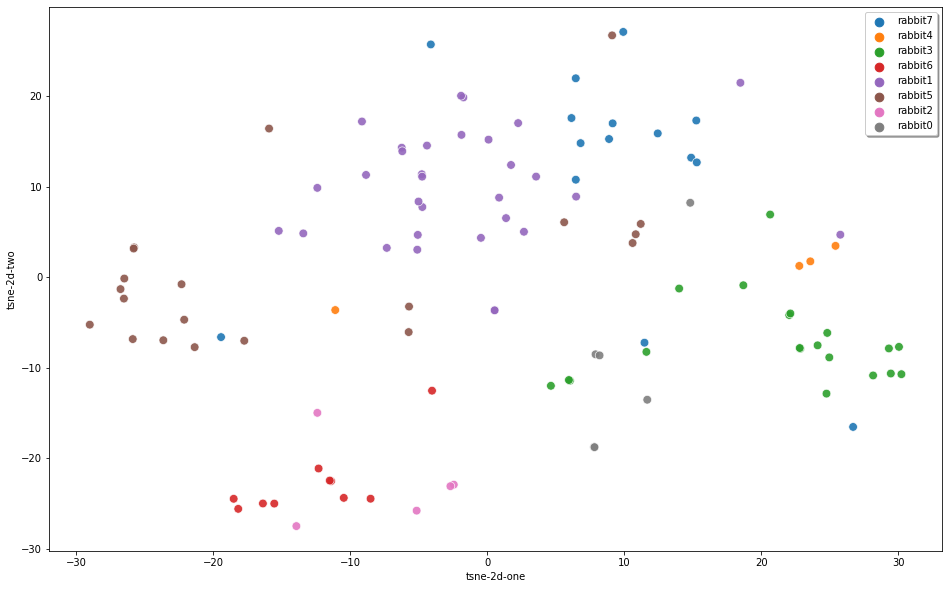

In [17]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    #palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.9,
    size="y",
    sizes = (75,75)
)
ax.legend(prop={'size': 10}, title=None, shadow=True)


for line in range(0,df.shape[0]):
    if line % 1 == 0:
        text = df.context[line]
        #text = textwrap.wrap(text, width=40)
        text = '\n'.join(text)
        #p1.text(df["tsne-2d-one"][line]+0.2, df["tsne-2d-two"][line], text, horizontalalignment='left', size='medium', color='black', weight='semibold')
       

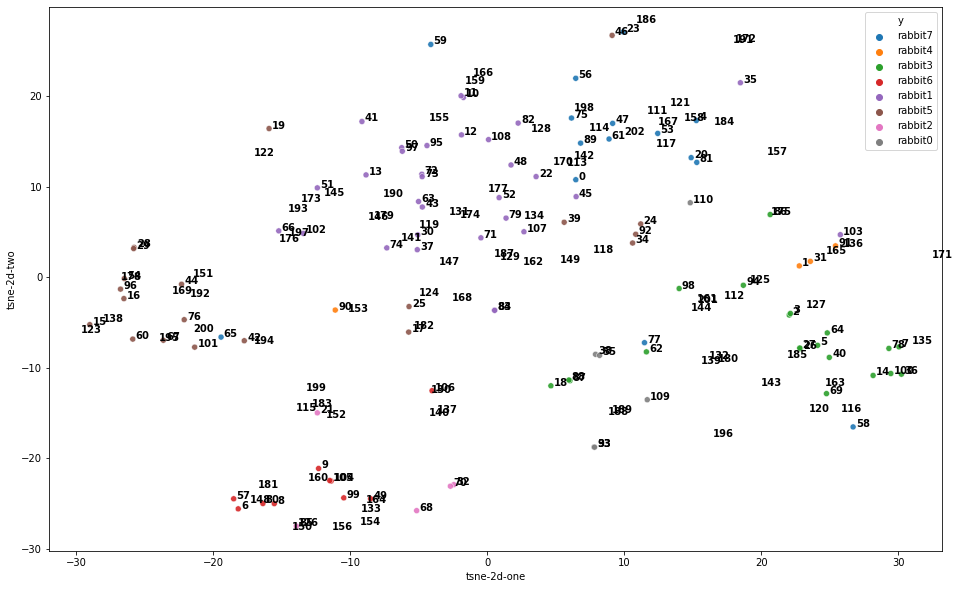

In [18]:
# get one with the indices annotated so we can pick out which sentence is where


df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    #palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.9
)

for line in range(0,df.shape[0]):
    if line % 1 == 0:
        #text = df.context[line]
        text = str(line)
        text = textwrap.wrap(text, width=40)
        text = '\n'.join(text)
        p1.text(df["tsne-2d-one"][line]+0.2, df["tsne-2d-two"][line], text, horizontalalignment='left', size='medium', color='black', weight='semibold')


In [19]:
"""
Print all the word tokens with their dataset indices for cross-reference with TSNE-diagram
"""

pd.set_option('display.max_colwidth', -1)
print(data['sentence'].to_string())

0      snags its circle through the eyes of a rabbit .                                                                                                                                                                                                                                                                                                                                                                                               
1      Peter Rabbit                                                                                                                                                                                                                                                                                                                                                                                                                                  
2      And you said you 'd do rabbit today did n't you ?                                                                    

<ipython-input-19-4a26fd0174ba>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [17]:
"""
Print all the word tokens with their cluster number for easy interpretation of graph colors / cross-reference with TSNE diagram
"""
for row in data.sort_values(by=['cluster_id']).itertuples():
    print (row.cluster_id, "\t", row.sentence)
    

0 	 To get their sows in the mating mood , pig breeders spray a manufactured porcine pheromone — chemically very similar to the human type — on their boars .
0 	 THE cold wind of technology could soon be blowing through Britain 's pig sties — helping farmers to reduce animal mortality and so increase their commercial fortunes .
0 	 To help them expand the herd further , the Russells now operate a ‘ Sponsor A Pig ’ scheme on their farm to enable people to pay for the upkeep of a chosen pig .
0 	 We began to tire of eating charred meat outside in the garden and , instead of the normal seasonal rise in pig prices , they moved sharply into reverse .
0 	 Since they 've had the marts , they do n't be keeping the pig days and sheep days no more .
0 	 Thinking out pig policy
0 	 Pig price stays low
0 	 Both will bring changes that will alter the demands on pig producers .
0 	 Weaners in the piglet nursery at the Easton Lodge pig unit come under the watchful eye of John Knighton , the farm 's h